In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *


In [2]:
%load_ext line_profiler
%load_ext memory_profiler

In [3]:
varinfo.clear()

In [4]:
module = fc.eightb.preselection.t8btag_minmass
dout = "yy_quadh"

In [5]:
altfile="yy_quadh_bkg10_soft025_md_allsig_{base}"
# signal = ObjIter([])
signal = ObjIter([ Tree(f, report=False, altfile=altfile) for f in tqdm(module.signal_list) ])
# signal = ObjIter([ Tree(f, report=False) for f in tqdm(module.full_signal_list) ])

# bkg = ObjIter([])
bkg = ObjIter([ Tree(module.Run2_UL18.QCD_B_List, altfile=altfile), Tree(module.Run2_UL18.TTJets, altfile=altfile)])

data = ObjIter([])
# data = ObjIter([ Tree(module.Run2_UL18.JetHT_Data_UL_List) ])

100%|██████████| 1/1 [00:02<00:00,  2.13s/it]


In [6]:
from utils.analysisUtils import eightb_analysis_v2 as analysis
analysis = analysis(
    signal=signal, bkg=bkg, data=data,
    sr_r=0.5, cr_r=1.0,
    # use_signal=[0,-2,-1]
)

In [7]:
analysis.run(runlist=['build_abcd'])

[running] reweight_bkg
[running] jet_kin_cuts
[skipping] plot_cutflow
[skipping] plot_ranker
[skipping] plot_t8btag_signal
[skipping] plot_eightb_signal
[skipping] plot_assigned_jet_kin
[skipping] plot_assigned_higgs_kin
[skipping] plot_assigned_y_kin
[skipping] plot_x_kin
[skipping] plot_res_m
[running] build_higgs_dm
Optimization terminated successfully.
         Current function value: 0.894833
         Iterations: 63
         Function evaluations: 157
[129.1  124.31 122.1  120.9 ]
[skipping] plot_assigned_higgs_m
[skipping] plot_y_higgs_m
[skipping] plot_abcd_variables
[running] build_abcd
[skipping] plot_abcd_composition
[skipping] plot_abcd_regions
[skipping] var_correlations
[skipping] plot_vr_datamc
[skipping] train_vr_bdt
[skipping] train_ar_bdt
[skipping] calc_limits
[skipping] calc_brazil


In [8]:
signal = analysis.signal
bkg = analysis.bkg
data = analysis.data

In [9]:
def jet_ht_pt30(t):
    t.extend(
        jet_ht_pt30=ak.sum( ak.where(t.jet_pt > 30, t.jet_pt, 0), axis=1 )
    )
(signal + bkg + data).apply(jet_ht_pt30)

[None, None, None, None, None]

100%|██████████| 1/1 [00:00<00:00,  5.94it/s]


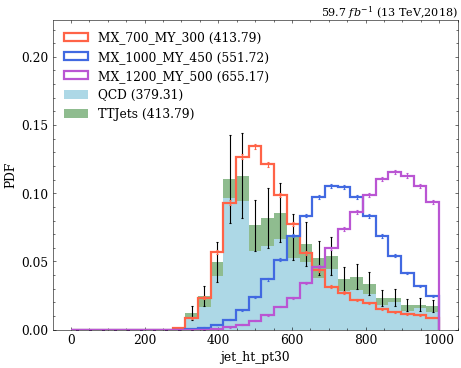

In [28]:
def best_cut(h):
    cumsum = h.histo.cumsum()/h.histo.sum()
    percentile = cumsum < 0.2
    best = np.where(percentile)[0][-1]
    return f"{h.bins[best]:0.2f}"

study.quick(
    signal+bkg,
    efficiency=True,
    varlist=['jet_ht_pt30'],
    binlist=[(0,1000,30)],
    h_label_stat=best_cut,
    legend=True,
    # **study.auroc,
)